# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [75]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from sklearn.linear_model import Lasso
from scipy.stats import norm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [76]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

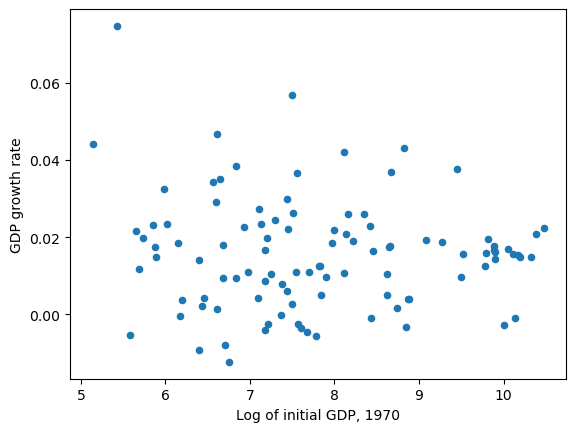

In [3]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth', ylabel='GDP growth rate', xlabel='Log of initial GDP, 1970');

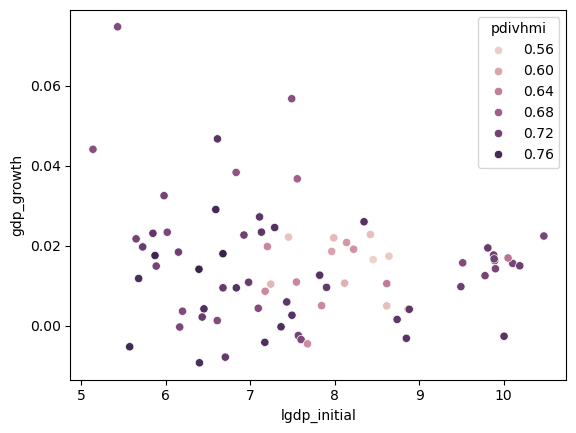

In [4]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='pdivhmi');

## Data-inspection
We begin by counting the number of observations for each variable, conditional on 'gdp_growth' and 'lgdp_initial' being non-missing

In [77]:
# Filter the dataset to include only rows where 'gdp_growth' is non-missing
filtered_dat = dat[dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)]

# Count the number of times all variables in the filtered dataset are non-missing
non_missing_counts = filtered_dat.notnull().sum()
# Sort non_missing_counts from lowest to highest
sorted_non_missing_counts = non_missing_counts.sort_values()

# Do the same for each region (replicating the sorting in "sorted_non_missing_counts")
regions = ['africa', 'americas', 'asia', 'europe', 'oceania']
sorted_non_missing_counts_by_region = {}

for region in regions:
    region_subset = filtered_dat[filtered_dat[region] == 1]
    non_missing_counts_region = region_subset.notnull().sum()
    sorted_non_missing_counts_by_region[region] = non_missing_counts_region[sorted_non_missing_counts.index]

# Extract the sorted non-missing counts for each region
sorted_non_missing_counts_africa = sorted_non_missing_counts_by_region['africa']
sorted_non_missing_counts_americas = sorted_non_missing_counts_by_region['americas']
sorted_non_missing_counts_asia = sorted_non_missing_counts_by_region['asia']
sorted_non_missing_counts_europe = sorted_non_missing_counts_by_region['europe']
sorted_non_missing_counts_oceania = sorted_non_missing_counts_by_region['oceania']

# Create a DataFrame to present the non-missing counts for each region
non_missing_counts_df = pd.DataFrame({
    'Variable': sorted_non_missing_counts.index,
    'All': sorted_non_missing_counts.values,
    'Africa': sorted_non_missing_counts_africa.values,
    'Americas': sorted_non_missing_counts_americas.values,
    'Asia': sorted_non_missing_counts_asia.values,
    'Europe': sorted_non_missing_counts_europe.values,
    'Oceania': sorted_non_missing_counts_oceania.values
})

# Display the DataFrame
print(non_missing_counts_df.to_string(index=False))
print(len(non_missing_counts_df))

                      Variable  All  Africa  Americas  Asia  Europe  Oceania
                         leb95   50      21        21     7       0        1
                         imr95   50      21        21     7       0        1
                       lt100km   51      21        21     8       0        1
                     mortality   51      19        22     8       1        1
                      excolony   55      18        16    11       8        2
                      democ00a   67      33        21    10       0        3
                        democ1   67      33        21    10       0        3
                   imputedmort   67      26        23    12       3        3
                       cons00a   70      33        24    10       0        3
                        logem4   71      28        25    12       3        3
    capital_growth_pct_gdp_now   77      22        19    17      17        2
                    pdivhmi_aa   77      33        19    14      11        0

## Collection of variables
In order to ease the following analysis, we group ALL the given variables into subcategories. Based on our data-inspection we exclude a range of variables from the analysis. These are grouped in 'vv_excluded'.

In [78]:
# all available variables
vv_outcome = ['gdp_growth']
vv_key_explanatory = ['lgdp_initial']

vv_institutions = ['dem', 'demCGV', 'demBMR', 'demreg', 
                   'currentinst', 'polity', 'polity2'] 
vv_geography = ['tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
                'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
                'africa',  'asia', 'oceania', 'americas']
vv_geneticdiversity = ['pdiv', 'pdiv_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst', 'ln_yst_aa', #NOTE THAT PD1500 OCCURS TWICE IN THE DATA ('PD1500' AND 'PD1500.1'). WE ONLY INCLUDE ONE HERE
                'legor_fr', 'legor_uk', 'pd1', 'pop1', 'pop_growth', 'population_initial','population_now']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] 
vv_economic = ['investment_rate', 'capital_growth_pct_gdp_initial', 'capital_growth_pct_gdp_now', 
               'gdp_now', 'gdp_pc_initial', 'gdp_pc_now', 'ginv', 'marketref']

            #due to large number of missing observations:
vv_excluded = ['leb95', 'imr95', 'mortality', 'imputedmort', 'logem4', 
               'lt100km', 'excolony', 'democ00a', 'democ1', 'cons00a',
               'pdivhmi', 'pdivhmi_aa',
             #due to lack of relevance or perfect correlation with included variables:
                'code', 'gdp_initial', 'lpop_initial',
             #reference variables:
                'pother', 'europe', 'lp_bl']

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ': vv_educ,
          'economic': vv_economic,
          }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


print(f'Variables in total: {len(vv_all["all"]+vv_key_explanatory+vv_outcome+vv_excluded)}')
print(f'We include {len(vv_all["all"])} control variables in total.')

Variables in total: 84
We include 64 control variables in total.


## Representativity of choosen variables
We check how many observations are have non-missing values for ALL the included variables. We compare this to the corresponding number of observations if all variables (except the three key variables) are excluded.

In [79]:
key_var = vv_outcome + vv_key_explanatory
all_included = vv_all['all'] + vv_outcome + vv_key_explanatory

non_missing_key_var = dat[key_var].notnull().all(axis=1).sum()
print(f'Non-missing values in key variables: {non_missing_key_var}')

non_missing_all_included = dat[all_included].notnull().all(axis=1).sum()
print(f'Non-missing values in all included variables: {non_missing_all_included}')

Non-missing values in key variables: 102
Non-missing values in all included variables: 50


We then check how the observations with non-missing values are distributed across the different geographic regions to get an idea about how representative the remaining observations are. We derive this geographic distribution for all observations ('All_share'), those observations with non-missing values for our key variables ('Key_share'), and those with non-missing values for all the included variables ('Included_share').

In [80]:
def shares_all(regions):
    shares_all = {}
    for region in regions:
        region_count_all = dat[region].sum()
        shares_all[region] = (region_count_all / len(dat)) * 100
    return shares_all

shares_all(regions)

{'africa': 25.233644859813083,
 'americas': 19.626168224299064,
 'asia': 22.897196261682243,
 'europe': 21.49532710280374,
 'oceania': 7.943925233644859}

In [9]:
shares_all = {}

for region in regions:
    region_count_all = dat[region].sum()
    shares_all[region] = (region_count_all / len(dat)) * 100

africa_share_all = shares_all['africa']
americas_share_all = shares_all['americas']
asia_share_all = shares_all['asia']
oceania_share_all = shares_all['oceania']
europe_share_all = shares_all['europe']

# Create a DataFrame to present the shares in a table
shares_df = pd.DataFrame({
    'Region': ['Africa', 'Americas', 'Asia', 'Oceania', 'Europe'],
    'All_share (%)': [round(africa_share_all, 4), 
                      round(americas_share_all, 4), 
                      round(asia_share_all, 4), 
                      round(oceania_share_all, 4), 
                      round(europe_share_all, 4)]
})

In [10]:
key_rows = dat[vv_outcome + vv_key_explanatory].notnull().all(axis=1)

shares_key = {}

for region in regions:
    region_rows_key = key_rows & (dat[region] == 1.0)
    region_count_key = region_rows_key.sum()
    shares_key[region] = (region_count_key / key_rows.sum()) * 100

africa_share_key = shares_key['africa']
americas_share_key = shares_key['americas']
asia_share_key = shares_key['asia']
europe_share_key = shares_key['europe']
oceania_share_key = shares_key['oceania']

shares_df['Key_share (%)'] = [
    round(africa_share_key, 4), 
    round(americas_share_key, 4), 
    round(asia_share_key, 4),
    round(oceania_share_key, 4), 
    round(europe_share_key, 4)
]

In [11]:
included_rows = dat[vv_all['all'] + vv_outcome + vv_key_explanatory].notnull().all(axis=1)

shares_included = {}

for region in regions:
    region_rows_included = included_rows & (dat[region] == 1.0)
    region_count_included = region_rows_included.sum()
    shares_included[region] = (region_count_included / included_rows.sum()) * 100

africa_share_included = shares_included['africa']
americas_share_included = shares_included['americas']
asia_share_included = shares_included['asia']
europe_share_included = shares_included['europe']
oceania_share_included = shares_included['oceania']

shares_df['Included_share (%)'] = [
    round(africa_share_included,4), 
    round(americas_share_included,4), 
    round(asia_share_included,4),
    round(oceania_share_included,4), 
    round(europe_share_included,4)
]
print(shares_df.to_string(index=False))

  Region  All_share (%)  Key_share (%)  Included_share (%)
  Africa        25.2336        34.3137                24.0
Americas        19.6262        26.4706                26.0
    Asia        22.8972        18.6275                22.0
 Oceania         7.9439         3.9216                 2.0
  Europe        21.4953        16.6667                26.0


We conclude that the included variables resemble the geographic distribution of the full data set to a reasonable extent

## Preparing data for analysis
We create a new data set consisting only of the non-missing observations and the included variables. We add a constant to the data (mainly relevant for OLS analysis), and base our analysis on this new dataset.

In [81]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))
vv_constant = ['constant']
print(dat.shape)


data = dat[included_rows]
print(data.shape)

(214, 86)
(50, 86)


In [82]:
data = data[vv_all['all'] + vv_outcome + vv_key_explanatory + vv_constant]
print(data.shape)
print(f'There are {data.isnull().sum().sum()} missing observations in the data.')

(50, 67)
There are 0 missing observations in the data.


In [83]:
g = data[vv_outcome].squeeze() #*100 to get it in percentage and not decimals
y0 = data[vv_key_explanatory].squeeze()
Z_basic = data[vv_all['all']]
Z = PolynomialFeatures(1, include_bias=False).fit_transform(Z_basic)

X = np.column_stack((y0,Z))
N = X.shape[0]

def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_tilde = standardize(X)
Z_tilde = standardize(Z)
y0_tilde = standardize(y0)

In [84]:
# Create a DataFrame with X_names as the index
Z_names = Z_basic.columns
X_names = Z_names.insert(len(Z_names), y0.name)
print(X_names)

Index(['dem', 'demCGV', 'demBMR', 'demreg', 'currentinst', 'polity', 'polity2',
       'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini',
       'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong',
       'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas',
       'pdiv', 'pdiv_aa', 'pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst',
       'ln_yst_aa', 'legor_fr', 'legor_uk', 'pd1', 'pop1', 'pop_growth',
       'population_initial', 'population_now', 'pprotest', 'pcatholic',
       'pmuslim', 'yellow', 'malfal', 'uvdamage', 'oilres', 'goldm', 'iron',
       'silv', 'zinc', 'ls_bl', 'lh_bl', 'investment_rate',
       'capital_growth_pct_gdp_initial', 'capital_growth_pct_gdp_now',
       'gdp_now', 'gdp_pc_initial', 'gdp_pc_now', 'ginv', 'marketref',
       'lgdp_initial'],
      dtype='object')


# Data analysis

## OLS estimation
NOTE: Using "original" variables (not standardized)

### Simple analysis

In [16]:
# Creating an matrix with y0 and a constant for simple OLS
simple_y0 = np.column_stack((np.ones(N),y0))
simple_g = np.array(g).reshape(-1,1)

#3. Run OLS
betas_simpleOLS = la.inv(simple_y0.T @ simple_y0) @ simple_y0.T @ simple_g
pd.DataFrame(betas_simpleOLS, index=['constant', 'lgdp_initial'], columns=['gdp_growth'])   

,gdp_growth
constant,0.031571
lgdp_initial,-0.001865


NOTE: It is not possible to use all the included variables with OLS as the rank condition is broken when p>n (as is the case here)

### Adding more controls

In [17]:
# Now, we need a matrix of all control variables and a constant
X_OLS = np.column_stack((np.ones(N), X))
g_OLS = np.array(g).reshape(-1,1)

betas_OLS = la.inv(X_OLS.T @ X_OLS) @ X_OLS.T @ g_OLS

#checking the rank condition
K = X_OLS.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

AssertionError: X does not have full rank

In [40]:
xs = vv_constant + vv_key_explanatory + vv_all['all']

pd.DataFrame({'β': betas_OLS[:,0]}, index=xs).round(3)

,β
constant,1.752330e+02
lgdp_initial,3.120970e+02
dem,7.977569e+15
demCGV,-7.977569e+15
demBMR,-2.513400e+01
...,...
gdp_now,-0.000000e+00
gdp_pc_initial,-0.000000e+00
gdp_pc_now,-8.100000e-02
ginv,7.500000e-02


## Lasso estimation

### Based on BRT penalty

#### Post-single Lasso

Step 1: Calculate BRT penalty

In [85]:
# Make a function that calculates BRT.
def BRT(X_tilde,g):
    
    (N, p) = X_tilde.shape
    sigma = np.std(g, ddof=1)
    c = 1.1
    alpha = 0.05
    penalty_BRT= (c * sigma) / np.sqrt(N) * norm.ppf(1 - alpha / (2*p))

    return penalty_BRT

penalty_BRT = BRT(X_tilde,g)
print("lambda_BRT =",penalty_BRT.round(4))

lambda_BRT = 0.0065


Step 2: Lasso g using y0 and Z.

In [109]:
# Implied estimates and selection
fit_BRTgx = Lasso(penalty_BRT, max_iter=10000).fit(X_tilde,g)
coeff_BRTgx = fit_BRTgx.coef_
intercept_BCCHgx = fit_BCCHgx.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHgx,3))
print('Coefficients: ', np.round(coeff_BRTgx,3))
Z_J_BRTgx = Z[:,coeff_BRTgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BRTgx.shape[1]))
selected_variables_BRTgx = (coeff_BRTgx != 0)
print('Selected varriables: ', X_names[selected_variables_BRTgx].to_list())

Intercept/constant:  0.016
Coefficients:  [-0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
  0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.]
The number of variables in Z_J is 0
Selected varriables:  []


Step 3: Regress g using y0 and Z_J

In [110]:
# Add a constant to X
xx = np.column_stack((np.ones(N),y0,Z_J_BRTgx))
yy = np.array(g).reshape(-1,1)

# Calculate OLS estimate
coefs_BRT_PSL = la.inv(xx.T@xx)@xx.T@yy

#print the coefficients
pd.DataFrame(coefs_BRT_PSL, index=['constant', 'lgdp_initial'], columns=['gdp_growth']) #same as for the simple OLS above

,gdp_growth
constant,0.031571
lgdp_initial,-0.001865


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PSL)

In [119]:
# Estimate variance
res_BRT_PSL = yy - xx@coefs_BRT_PSL
SSR_BRT_PSL = res_BRT_PSL.T@res_BRT_PSL
sigma2_BRT_PSL = SSR_BRT_PSL/(N-xx.shape[1])
var_BRT_PSL = sigma2_BRT_PSL*la.inv(xx.T@xx)

# Calculate standard errors
se_BRT_PSL = np.sqrt(np.diagonal(var_BRT_PSL)).reshape(-1, 1)
se_BRT_PSL=se_BRT_PSL[1][0]

# Display standard error
print("se_BRT_PSL = ",se_BRT_PSL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BRT_PSL  = coefs_BRT_PSL[1][0]-q*se_BRT_PSL
CI_high_BRT_PSL = coefs_BRT_PSL[1][0]+q*se_BRT_PSL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PSL) = ",(CI_low_BRT_PSL.round(5),CI_high_BRT_PSL.round(5)))

se_BRT_PSL =  0.00126
Confidence interval for β_y0 (BRT_PSL) =  (-0.00434, 0.00061)


**Conclusion (BRT_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [112]:
penalty_BRTy0z = BRT(Z_tilde, y0)

In [113]:
# Run Lasso
fit_BRTy0z = Lasso(penalty_BRTy0z, max_iter=10000).fit(Z_tilde, y0)
coeff_BRTy0z=fit_BRTy0z.coef_
intercept_BRTy0z = fit_BRTy0z.intercept_

print('Intercept/constant: ', np.round(intercept_BRTy0z,5))
print('Coefficients: ', np.round(coeff_BRTy0z,5))

selected_variables_BRTy0z = (coeff_BRTy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BRTy0z].to_list())

Intercept/constant:  8.16408
Coefficients:  [ 0.       0.       0.       0.      -0.       0.       0.      -0.
 -0.      -0.      -0.       0.      -0.       0.      -0.      -0.
 -0.      -0.       0.       0.      -0.      -0.       0.      -0.
 -0.      -0.       0.       0.      -0.       0.      -0.       0.
 -0.      -0.       0.       0.       0.      -0.       0.      -0.
 -0.      -0.      -0.       0.       0.      -0.      -0.      -0.
 -0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      -0.       0.       0.48687  0.       0.       0.     ]
Selected varriables:  ['gdp_pc_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [120]:
# Calculate residuals
res_BRTgx = g - fit_BRTgx.predict(X_tilde)
res_BRTgxz = res_BRTgx + y0_tilde*coeff_BRTgx[0]
res_BRTy0z=y0-fit_BRTy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BRTy0z@res_BRTgxz
denom = res_BRTy0z@y0
coef_BRT_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BRT_PDL) = ",coef_BRT_PDL.round(5))

Coefficient for β_y0 (BRT_PDL) =  -0.00218


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PDL)

In [127]:
# Calculate variance    
num = res_BRTy0z**2@res_BRTgx**2/N
denom = (res_BRTy0z.T@res_BRTy0z/N)**2
sigma2_BRT_PDL = num/denom

# Calculate standard error
se_BRT_PDL = np.sqrt(sigma2_BRT_PDL/N)

# Display standard error
print("se_BRT_PDL = ",se_BRT_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BRT_PDL  = coef_BRT_PDL-q*se_BRT_PDL
CI_high_BRT_PDL = coef_BRT_PDL+q*se_BRT_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PDL) = ",(CI_low_BRT_PDL.round(5),CI_high_BRT_PDL.round(5)))



se_BRT_PDL =  0.00153
Confidence interval for β_y0 (BRT_PDL) =  (-0.00517, 0.00081)


**Conclusion (BRT_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Based on BCCH penalty

#### Post-single Lasso

Step 1: Calculate BCCH penalty

In [128]:
def BCCH(X_tilde,g):

    # BCCH pilot penalty
    n,p = X.shape
    c = 1.1
    alpha = 0.05
    gXscale = (np.max((X_tilde.T ** 2) @ ((g-np.mean(g)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * gXscale # Note: Have divided by 2 due to Python definition of Lasso
    
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(X_tilde,g).predict(X_tilde)

    # Updated penalty
    eps = g - pred #eps: epsilon/residuals 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p))*epsXscale

    return penalty_BCCH

penalty_BCCH = BCCH(X_tilde,g)
print("lambda_BCCH =",penalty_BCCH.round(4))

lambda_BCCH = 0.0097


Step 2: Lasso g using y0 and Z.

In [129]:
# Implied estimates and selection
fit_BCCHgx = Lasso(penalty_BCCH, max_iter=10000).fit(X_tilde,g)
coeff_BCCHgx = fit_BCCHgx.coef_
intercept_BCCHgx = fit_BCCHgx.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHgx,3))
print('Coefficients: ', np.round(coeff_BCCHgx,3))
Z_J_BCCHgx = Z[:,coeff_BCCHgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BCCHgx.shape[1]))
selected_variables_BCCHgx = (coeff_BCCHgx != 0)
print('Selected varriables: ', X_names[selected_variables_BCCHgx].to_list())

Intercept/constant:  0.016
Coefficients:  [-0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
  0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.
  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.]
The number of variables in Z_J is 0
Selected varriables:  []


Step 3 and 4 will yield the same result as for BRT_PSL, as BCCH_PSL return the same Z_J (containing no control variables) 

**Conclusion (BCCH_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [ ]:
penalty_BCCHy0z = BCCH(Z_tilde, y0)

In [136]:
# Run Lasso
fit_BCCHy0z = Lasso(penalty_BCCHy0z, max_iter=10000).fit(Z_tilde, y0)
coeff_BCCHy0z=fit_BCCHy0z.coef_
intercept_BCCHy0z = fit_BCCHy0z.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHy0z,5))
print('Coefficients: ', np.round(coeff_BCCHy0z,5))

selected_variables_BCCHy0z = (coeff_BCCHy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BCCHy0z].to_list())

Intercept/constant:  8.16408
Coefficients:  [ 0.       0.       0.       0.      -0.       0.       0.      -0.
 -0.      -0.      -0.      -0.      -0.       0.      -0.      -0.
 -0.      -0.       0.       0.      -0.      -0.      -0.      -0.
 -0.      -0.       0.      -0.       0.       0.      -0.       0.
 -0.      -0.       0.       0.      -0.      -0.       0.      -0.
 -0.      -0.      -0.       0.       0.      -0.      -0.      -0.
 -0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.      -0.       0.       0.12629  0.       0.       0.     ]
Selected varriables:  ['gdp_pc_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [137]:
# Calculate residuals
res_BCCHgx = g - fit_BCCHgx.predict(X_tilde)
res_BCCHgxz = res_BCCHgx + y0_tilde*coeff_BCCHgx[0]
res_BCCHy0z=y0-fit_BCCHy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BCCHy0z@res_BCCHgxz
denom = res_BCCHy0z@y0
coef_BCCH_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BCCH_PDL) = ",coef_BCCH_PDL.round(5))

Coefficient for β_y0 (BCCH_PDL) =  -0.00193


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BCCH_PDL)

In [138]:
# Calculate variance    
num = res_BCCHy0z**2@res_BCCHgx**2/N
denom = (res_BCCHy0z.T@res_BCCHy0z/N)**2
sigma2_BCCH_PDL = num/denom

# Calculate standard error
se_BCCH_PDL = np.sqrt(sigma2_BCCH_PDL/N)

# Display standard error
print("se_BCCH_PDL = ",se_BCCH_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BCCH_PDL  = coef_BCCH_PDL-q*se_BCCH_PDL
CI_high_BCCH_PDL = coef_BCCH_PDL+q*se_BCCH_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BCCH_PDL) = ",(CI_low_BCCH_PDL.round(5),CI_high_BCCH_PDL.round(5)))



se_BCCH_PDL =  0.00114
Confidence interval for β_y0 (BCCH_PDL) =  (-0.00416, 0.0003)


**Conclusion (BCCH_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

# Analysis 2 (based on dataset with fewer variables / more observations)

## Preparing data for analysis
First we create a dataset (data2) consisting of those observations which have non-missing values for gdp_growth, lgdp_initial and investment_rate (these variables are explictly mentioned in the assignment text).
We then subset data2 such that it include only variables with zero missing values.

In [35]:
included_rows2 = dat[vv_outcome + vv_key_explanatory + ['investment_rate'] ].notnull().all(axis=1)
data2 = dat[included_rows2]

data2 = data2.dropna(axis=1)

print(f'The number of observations left in data2 is {data2.shape[0]}.')
print(f'The number of variables with no missing values is {data2.shape[1]}.')
print(f'The remaining variables are: {data2.columns.to_list()}')

The number of observations left in data2 is 99.
The number of variables with no missing values is 28.
The remaining variables are: ['code', 'uvdamage', 'pdiv', 'legor_uk', 'legor_fr', 'area', 'cenlong', 'africa', 'europe', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim', 'pother', 'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now', 'gdp_initial', 'gdp_now', 'investment_rate', 'gdp_growth', 'pop_growth', 'lgdp_initial', 'lpop_initial', 'constant']


In [139]:
g = data2[vv_outcome].squeeze() #*100 to get it in percentage and not decimals
y0 = data2[vv_key_explanatory].squeeze()
Z_basic = data2.drop(["gdp_growth", "lgdp_initial",  # Drop outcome and key explanatory variable
                      "code", "constant", "gdp_initial", "lpop_initial", "pother", "europe"], axis=1) # Drop irrelevant/perfectly correlated/reference variables
Z = PolynomialFeatures(1, include_bias=False).fit_transform(Z_basic)
X = np.column_stack((y0,Z))
N = X.shape[0]

def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_tilde = standardize(X)
Z_tilde = standardize(Z)
y0_tilde = standardize(y0)

print(f'The number of variables in Z is {Z.shape[1]}.')

The number of variables in Z is 20.


In [140]:
# Create a DataFrame with X_names as the index
Z_names = Z_basic.columns
X_names = Z_names.insert(len(Z_names), y0.name)
print(X_names)

Index(['uvdamage', 'pdiv', 'legor_uk', 'legor_fr', 'area', 'cenlong', 'africa',
       'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim',
       'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now',
       'gdp_now', 'investment_rate', 'pop_growth', 'lgdp_initial'],
      dtype='object')


## Lasso estimation

### Based on BRT penalty

#### Post-single Lasso

Step 1: Calculate BRT penalty

In [141]:
# Make a function that calculates BRT.
def BRT(X_tilde,g):
    
    (N, p) = X_tilde.shape
    sigma = np.std(g, ddof=1)
    c = 1.1
    alpha = 0.05
    penalty_BRT= (c * sigma) / np.sqrt(N) * norm.ppf(1 - alpha / (2*p))

    return penalty_BRT

penalty_BRT = BRT(X_tilde,g)
print("lambda_BRT =",penalty_BRT.round(4))

lambda_BRT = 0.005


Step 2: Lasso g using y0 and Z.

In [142]:
# Implied estimates and selection
fit_BRTgx = Lasso(penalty_BRT, max_iter=10000).fit(X_tilde,g)
coeff_BRTgx = fit_BRTgx.coef_
intercept_BCCHgx = fit_BCCHgx.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHgx,3))
print('Coefficients: ', np.round(coeff_BRTgx,3))
Z_J_BRTgx = Z[:,coeff_BRTgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BRTgx.shape[1]))
selected_variables_BRTgx = (coeff_BRTgx != 0)
print('Selected varriables: ', X_names[selected_variables_BRTgx].to_list())

Intercept/constant:  0.016
Coefficients:  [-0.    -0.    -0.     0.    -0.     0.     0.    -0.     0.002 -0.
 -0.    -0.    -0.    -0.     0.001  0.     0.     0.     0.     0.
 -0.   ]
The number of variables in Z_J is 2
Selected varriables:  ['oceania', 'population_now']


Step 3: Regress g using y0 and Z_J

In [145]:
# Add a constant to X
xx = np.column_stack((np.ones(N),y0,Z_J_BRTgx))
yy = np.array(g).reshape(-1,1)

# Calculate OLS estimate
coefs_BRT_PSL = la.inv(xx.T@xx)@xx.T@yy

#print the coefficients
pd.DataFrame(coefs_BRT_PSL, index=[['constant', 'lgdp_initial']+X_names[selected_variables_BRTgx].to_list()], columns=['gdp_growth']) #same as for the simple OLS above

,gdp_growth
constant,6.860738e-03
lgdp_initial,5.888391e-04
oceania,1.446844e-02
population_now,4.532296e-11


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PSL)

In [146]:
# Estimate variance
res_BRT_PSL = yy - xx@coefs_BRT_PSL
SSR_BRT_PSL = res_BRT_PSL.T@res_BRT_PSL
sigma2_BRT_PSL = SSR_BRT_PSL/(N-xx.shape[1])
var_BRT_PSL = sigma2_BRT_PSL*la.inv(xx.T@xx)

# Calculate standard errors
se_BRT_PSL = np.sqrt(np.diagonal(var_BRT_PSL)).reshape(-1, 1)
se_BRT_PSL=se_BRT_PSL[1][0]

# Display standard error
print("se_BRT_PSL = ",se_BRT_PSL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BRT_PSL  = coefs_BRT_PSL[1][0]-q*se_BRT_PSL
CI_high_BRT_PSL = coefs_BRT_PSL[1][0]+q*se_BRT_PSL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PSL) = ",(CI_low_BRT_PSL.round(5),CI_high_BRT_PSL.round(5)))

se_BRT_PSL =  0.00095
Confidence interval for β_y0 (BRT_PSL) =  (-0.00126, 0.00244)


**Conclusion (BRT_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [147]:
penalty_BRTy0z = BRT(Z_tilde, y0)

In [148]:
# Run Lasso
fit_BRTy0z = Lasso(penalty_BRTy0z, max_iter=10000).fit(Z_tilde, y0)
coeff_BRTy0z=fit_BRTy0z.coef_
intercept_BRTy0z = fit_BRTy0z.intercept_

print('Intercept/constant: ', np.round(intercept_BRTy0z,5))
print('Coefficients: ', np.round(coeff_BRTy0z,5))

selected_variables_BRTy0z = (coeff_BRTy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BRTy0z].to_list())

Intercept/constant:  7.81955
Coefficients:  [-0.      -0.      -0.       0.      -0.      -0.      -0.      -0.
  0.       0.       0.       0.      -0.      -0.      -0.       0.72188
  0.       0.       0.      -0.     ]
Selected varriables:  ['gdp_pc_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [149]:
# Calculate residuals
res_BRTgx = g - fit_BRTgx.predict(X_tilde)
res_BRTgxz = res_BRTgx + y0_tilde*coeff_BRTgx[0]
res_BRTy0z=y0-fit_BRTy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BRTy0z@res_BRTgxz
denom = res_BRTy0z@y0
coef_BRT_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BRT_PDL) = ",coef_BRT_PDL.round(5))

Coefficient for β_y0 (BRT_PDL) =  -0.00102


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BRT_PDL)

In [150]:
# Calculate variance    
num = res_BRTy0z**2@res_BRTgx**2/N
denom = (res_BRTy0z.T@res_BRTy0z/N)**2
sigma2_BRT_PDL = num/denom

# Calculate standard error
se_BRT_PDL = np.sqrt(sigma2_BRT_PDL/N)

# Display standard error
print("se_BRT_PDL = ",se_BRT_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BRT_PDL  = coef_BRT_PDL-q*se_BRT_PDL
CI_high_BRT_PDL = coef_BRT_PDL+q*se_BRT_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BRT_PDL) = ",(CI_low_BRT_PDL.round(5),CI_high_BRT_PDL.round(5)))



se_BRT_PDL =  0.00208
Confidence interval for β_y0 (BRT_PDL) =  (-0.00509, 0.00305)


**Conclusion (BRT_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Based on BCCH penalty

#### Post-single Lasso

Step 1: Calculate BCCH penalty

In [151]:
def BCCH(X_tilde,g):

    # BCCH pilot penalty
    n,p = X.shape
    c = 1.1
    alpha = 0.05
    gXscale = (np.max((X_tilde.T ** 2) @ ((g-np.mean(g)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * gXscale # Note: Have divided by 2 due to Python definition of Lasso
    
    #Create predicted value using Lasso 
    pred = Lasso(alpha=penalty_pilot).fit(X_tilde,g).predict(X_tilde)

    # Updated penalty
    eps = g - pred #eps: epsilon/residuals 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p))*epsXscale

    return penalty_BCCH

penalty_BCCH = BCCH(X_tilde,g)
print("lambda_BCCH =",penalty_BCCH.round(4))

lambda_BCCH = 0.0159


Step 2: Lasso g using y0 and Z.

In [152]:
# Implied estimates and selection
fit_BCCHgx = Lasso(penalty_BCCH, max_iter=10000).fit(X_tilde,g)
coeff_BCCHgx = fit_BCCHgx.coef_
intercept_BCCHgx = fit_BCCHgx.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHgx,3))
print('Coefficients: ', np.round(coeff_BCCHgx,3))
Z_J_BCCHgx = Z[:,coeff_BCCHgx[1:]!=0] # Note: We use Z and not Z_stan

# Display number of variables in Z_J
print("The number of variables in Z_J is {}".format(Z_J_BCCHgx.shape[1]))
selected_variables_BCCHgx = (coeff_BCCHgx != 0)
print('Selected varriables: ', X_names[selected_variables_BCCHgx].to_list())

Intercept/constant:  0.016
Coefficients:  [-0. -0. -0.  0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.
  0.  0. -0.]
The number of variables in Z_J is 0
Selected varriables:  []


Step 3 and 4 will yield the same result as for BRT_PSL, as BCCH_PSL return the same Z_J (containing no control variables) 

**Conclusion (BCCH_PSL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**

### Post-double Lasso

Step 1 & 2: Same as for Post-single Lasso

Step 3: Lasso D using Z

In [153]:
penalty_BCCHy0z = BCCH(Z_tilde, y0)

In [154]:
# Run Lasso
fit_BCCHy0z = Lasso(penalty_BCCHy0z, max_iter=10000).fit(Z_tilde, y0)
coeff_BCCHy0z=fit_BCCHy0z.coef_
intercept_BCCHy0z = fit_BCCHy0z.intercept_

print('Intercept/constant: ', np.round(intercept_BCCHy0z,5))
print('Coefficients: ', np.round(coeff_BCCHy0z,5))

selected_variables_BCCHy0z = (coeff_BCCHy0z != 0)
print('Selected varriables: ', Z_names[selected_variables_BCCHy0z].to_list())

Intercept/constant:  7.81955
Coefficients:  [-0.      -0.      -0.       0.       0.      -0.      -0.      -0.
  0.       0.       0.       0.      -0.      -0.      -0.       0.55406
  0.       0.       0.      -0.     ]
Selected varriables:  ['gdp_pc_initial']


Step 4: Estimate ${\beta}_{y0}$ (called 'alpha' in the slides)

In [155]:
# Calculate residuals
res_BCCHgx = g - fit_BCCHgx.predict(X_tilde)
res_BCCHgxz = res_BCCHgx + y0_tilde*coeff_BCCHgx[0]
res_BCCHy0z=y0-fit_BCCHy0z.predict(Z_tilde)

# Calculate beta_y0
num = res_BCCHy0z@res_BCCHgxz
denom = res_BCCHy0z@y0
coef_BCCH_PDL = num/denom

# Display beta_y0
print("Coefficient for β_y0 (BCCH_PDL) = ",coef_BCCH_PDL.round(5))

Coefficient for β_y0 (BCCH_PDL) =  -0.00129


Calculating the 95 % confidence interval for ${\beta}_{y0}$ (BCCH_PDL)

In [156]:
# Calculate variance    
num = res_BCCHy0z**2@res_BCCHgx**2/N
denom = (res_BCCHy0z.T@res_BCCHy0z/N)**2
sigma2_BCCH_PDL = num/denom

# Calculate standard error
se_BCCH_PDL = np.sqrt(sigma2_BCCH_PDL/N)

# Display standard error
print("se_BCCH_PDL = ",se_BCCH_PDL.round(5))

# Calculate the z statistic that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_BCCH_PDL  = coef_BCCH_PDL-q*se_BCCH_PDL
CI_high_BCCH_PDL = coef_BCCH_PDL+q*se_BCCH_PDL

# Display confidence interval
print("Confidence interval for β_y0 (BCCH_PDL) = ",(CI_low_BCCH_PDL.round(5),CI_high_BCCH_PDL.round(5)))



se_BCCH_PDL =  0.002
Confidence interval for β_y0 (BCCH_PDL) =  (-0.00521, 0.00262)


**Conclusion (BCCH_PDL): data is not consistent with beta convergence (${\beta}_{y0}$ is insignificant)**